## <center>Regularization</center>
<center>Shan-Hung Wu & DataLab</center>
<center>Fall 2023</center>

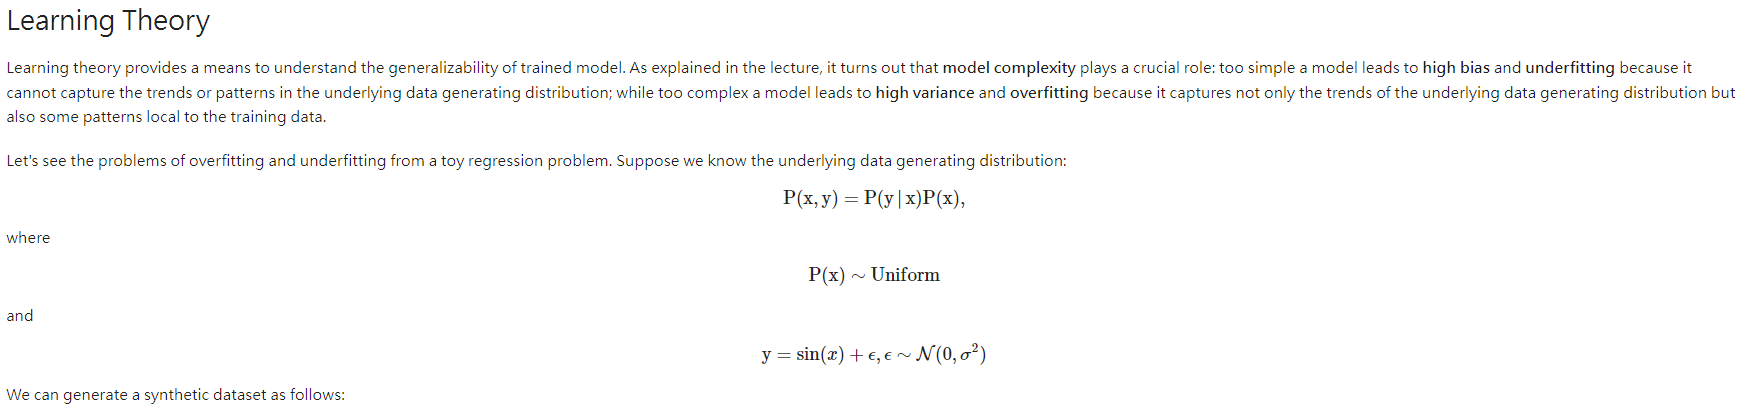

In [1]:
%matplotlib inline
from pylab import *
from sklearn.model_selection import train_test_split

import os
if not os.path.exists("output/") : os.mkdir("output/")
if not os.path.exists("data/") : os.mkdir("data/")

# 隱藏一些不太重要的警告訊息，以使程式碼的輸出更整潔或減少不必要的干擾。
import warnings
warnings.filterwarnings("ignore")

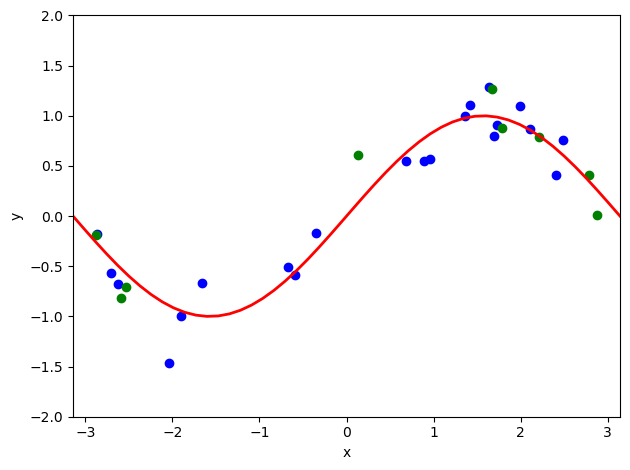

In [2]:
def gen_data(num_data, sigma):
    x = 2 * np.pi * (np.random.rand(num_data) - 0.5)
    y = np.sin(x) + np.random.normal(0, sigma, num_data) # sin function + white noise
    return (x, y)

num_data = 30
sigma = 0.2
x, y = gen_data(num_data, sigma)
x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.3, random_state=0)

plt.scatter(x_train, y_train, color='blue')
plt.scatter(x_test, y_test, color='green')

# linspace: 創建一個名為 x_grid 的NumPy數組，其中包含從 -π 到 π 之間的均勻間隔的數值
x_grid = np.linspace(-1*np.pi, 1*np.pi)
sin_x = np.sin(x_grid)
plt.plot(x_grid, sin_x, color ='red', linewidth = 2)

plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-np.pi, np.pi)
plt.ylim(-2, 2)
plt.tight_layout()
plt.savefig('./output/fig-dataset-sin.png', dpi=300)
plt.show()

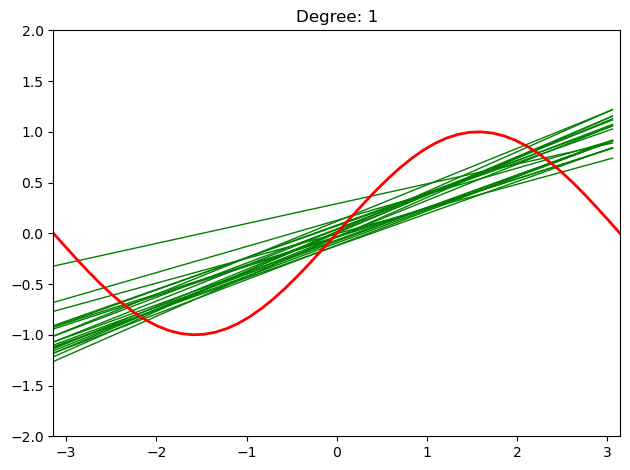

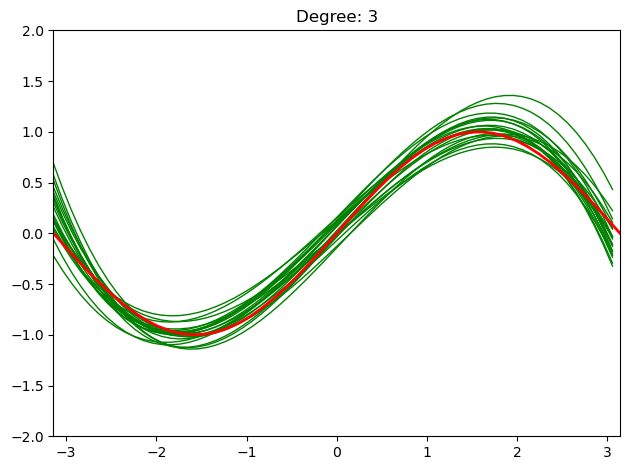

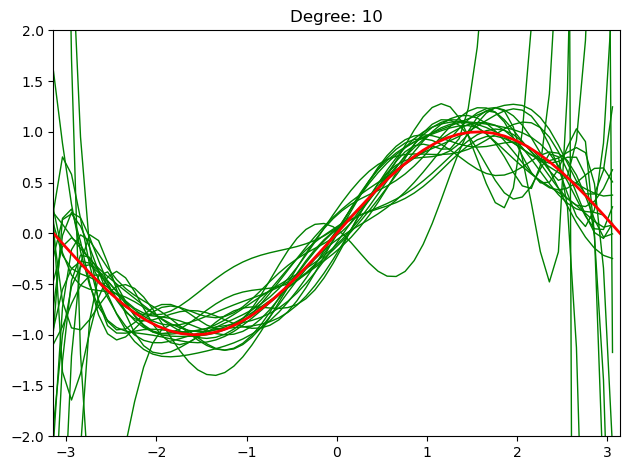

In [3]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

degree = [1, 3, 10]
std_list = []
for d in degree:
    X_fit = np.arange(-np.pi, np.pi, .1)[:, np.newaxis]
    poly = PolynomialFeatures(degree=d)
    
    for i in range(20):
        x, y = gen_data(num_data, sigma)
        x_train, x_test, y_train, y_test = train_test_split(
            x, y, test_size=0.3, random_state=0)
        
        regr = LinearRegression()
        regr = regr.fit(poly.fit_transform(x_train[:,np.newaxis]), 
                        y_train[:,np.newaxis])

        y_fit = regr.predict(poly.transform(X_fit))
        plt.plot(X_fit, y_fit, 
                 color='green', lw=1)
    
    x_grid = np.linspace(-1*np.pi, 1*np.pi)
    sin_x = np.sin(x_grid)
    plt.plot(x_grid, sin_x, color='red', linewidth = 2)
    
    plt.title('Degree: %d' %d)
    plt.xlim(-np.pi, np.pi)
    plt.ylim(-2, 2)
    plt.tight_layout()
    plt.savefig('./output/fig-polyreg-%d.png' % d, dpi=300)
    plt.show()

When $P=1$, the polynomial is too simple to capture the trend of the $sin$ function. On the other hand, when $P=10$, the polynomial becomes too complex such that it captures the undesirable patterns of noises.

NOTE: regression is bad at extrapolation. You can see that the shape of a fitted polynomial differs a lot from the $sin$ function outside the region where training points reside.

### Error Curves and Model Complexity

One important conclusion we get from learning theory is that the model complexity plays a key role in generalization performance of a model. Let's plot the training and testing errors over different model complexities in our regression problem:

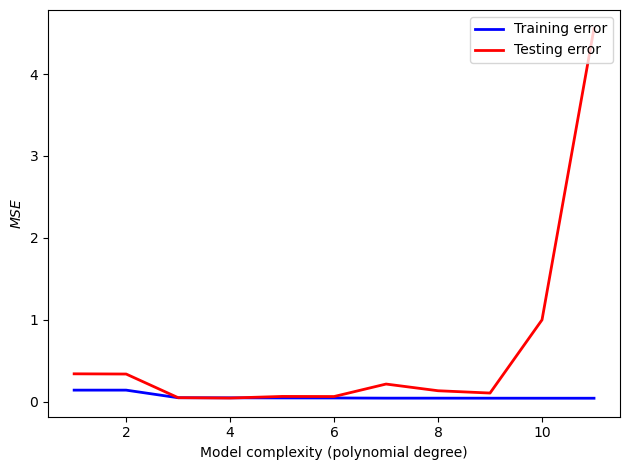

In [5]:
from sklearn.metrics import mean_squared_error

num_data = 50
x, y = gen_data(num_data, sigma)
x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.3, random_state=0)

mse_train = []
mse_test = []

max_degree = 12

for d in range(1, max_degree):
    poly = PolynomialFeatures(degree=d)
    X_train_poly = poly.fit_transform(x_train[:,newaxis])
    X_test_poly = poly.transform(x_test[:,newaxis])
    
    regr = LinearRegression()
    regr = regr.fit(X_train_poly, y_train)
    y_train_pred = regr.predict(X_train_poly)
    y_test_pred = regr.predict(X_test_poly)
    
    mse_train.append(mean_squared_error(y_train, y_train_pred))
    mse_test.append(mean_squared_error(y_test, y_test_pred))
    

plt.plot(range(1, max_degree), mse_train, label = 'Training error', color = 'blue', linewidth = 2)
plt.plot(range(1, max_degree), mse_test, label = 'Testing error', color = 'red', linewidth = 2)
plt.legend(loc='upper right')
plt.xlabel('Model complexity (polynomial degree)')
plt.ylabel('$MSE$')
plt.tight_layout()
plt.savefig('./output/fig-error-curve.png', dpi=300)
plt.show()

We can see that the training error (blue curve) decrease as the model complexity increases. However, the testing error (red curve) decreases at the beginning but increases latter. We see a clear bias-variance tradeoff as discussed in the lecture.

### Learning Curve and Sample Complexity

Although the error curve above visualizes the impact of model complexity, the bias-variance tradeoff holds only when you have sufficient training examples. The bounding methods of learning theory tell us that a model is likely to overfit regardless of it complexity when the size of training set is small. The learning curves are a useful tool for understanding how much training examples are sufficient:

In [7]:
def mse(model, X, y):
    return ((model.predict(X) - y)**2).mean()

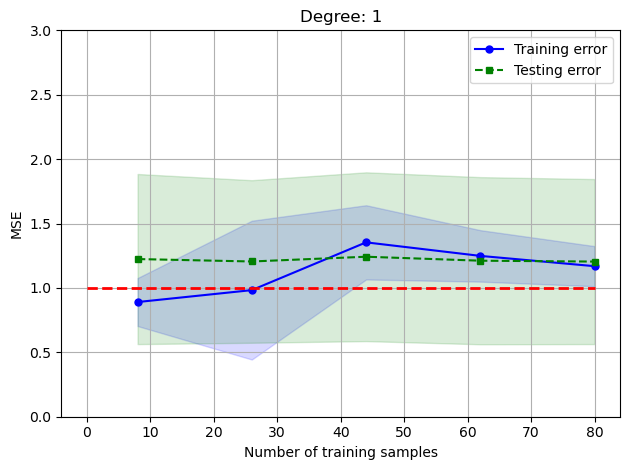

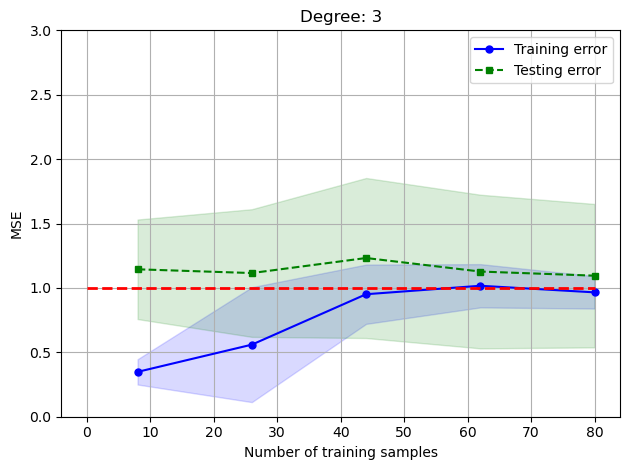

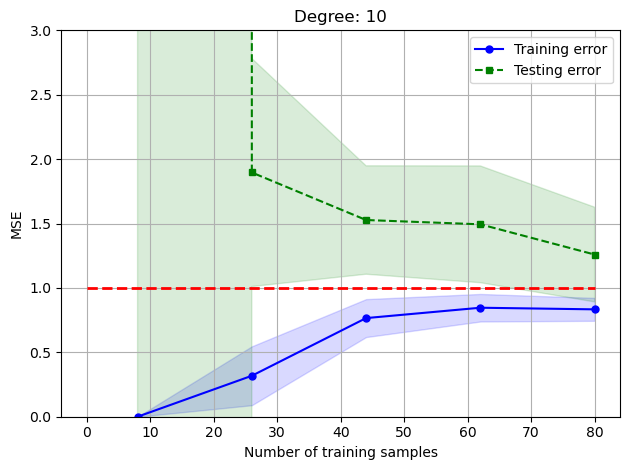

In [8]:
from sklearn.model_selection import learning_curve

num_data = 100
sigma = 1
degree = [1, 3, 10]
x, y = gen_data(num_data, sigma)
for d in degree:
    poly = PolynomialFeatures(degree=d)
    X = poly.fit_transform(x[:,np.newaxis])

    lr = LinearRegression()
    train_sizes, train_scores, test_scores = learning_curve(estimator=lr, X=X, y=y, scoring=mse)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(train_sizes, train_mean,
        color='blue', marker='o',
        markersize=5,
        label='Training error')
    plt.fill_between(train_sizes,
        train_mean+train_std,
        train_mean-train_std,
        alpha=0.15, color='blue')
    
    plt.plot(train_sizes, test_mean,
        color='green', linestyle='--',
        marker='s', markersize=5,
        label='Testing error')
    plt.fill_between(train_sizes,
        test_mean+test_std,
        test_mean-test_std,
        alpha=0.15, color='green')
    
    plt.hlines(y=sigma, xmin=0, xmax=80, color='red', linewidth=2, linestyle='--')
    
    plt.title('Degree: %d' % d)
    plt.grid()
    plt.xlabel('Number of training samples')
    plt.ylabel('MSE')
    plt.legend(loc='upper right')
    plt.ylim([0, 3])
    plt.tight_layout()
    plt.savefig('./output/fig-learning-curve-%d.png' % d, dpi=300)
    plt.show()

We can see that in these regression tasks, a polynomial of any degree almost always overfits the training data when the model size is small, resulting in poor testing performance. This indicates that we should collect more data instead of sitting in front of the computer and play with the models. You may also try other models as different models has different sample complexity (i.e., number of samples required to successfully train a model).

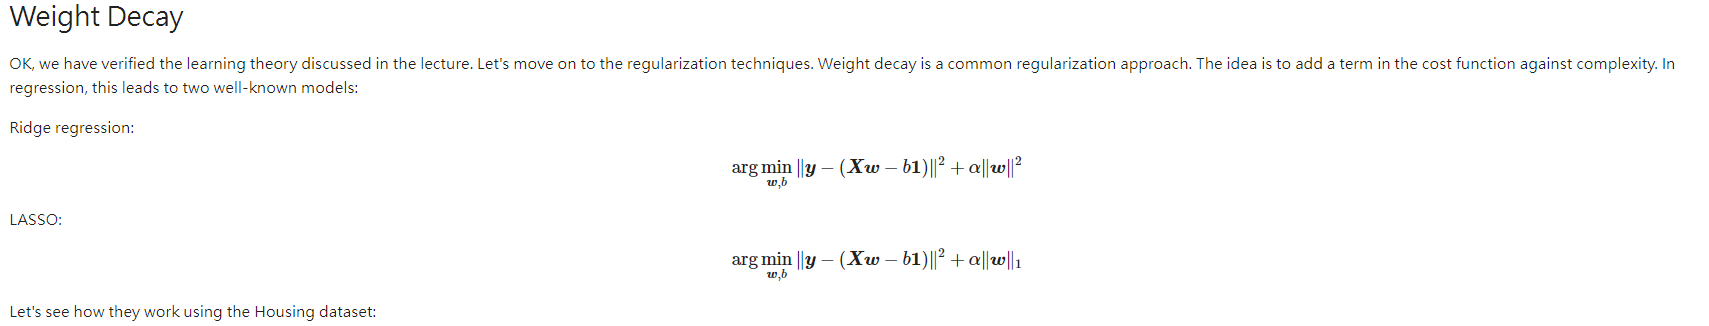

In [9]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/'
                 'housing/housing.data',
                 header=None,
                 sep='\s+')

df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 
              'NOX', 'RM', 'AGE', 'DIS', 'RAD', 
              'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


Remember that for weight decay to work properly, we need to ensure that all our features are on comparable scales:

In [10]:
from sklearn.preprocessing import StandardScaler

X = df.iloc[:, :-1].values
y = df['MEDV'].values

sc_x = StandardScaler()
X_std = sc_x.fit_transform(X)

### Ridge Regression
We know that an unregularized polynomial regressor with degree $P=3$ will overfit the training data and has bad generalizability. Let's regularize its $L^2$-norm to see if we can get a better testing error:

In [11]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X_std)
X_train, X_test, y_train, y_test = train_test_split(
    X_poly, y, test_size=0.3, random_state=0)

for a in [0, 1, 10, 100, 1000]:
    lr_rg = Ridge(alpha=a)
    lr_rg.fit(X_train, y_train)

    y_train_pred = lr_rg.predict(X_train)
    y_test_pred = lr_rg.predict(X_test)

    print('\n[Alpha = %d]' % a )
    print('MSE train: %.2f, test: %.2f' % (
                    mean_squared_error(y_train, y_train_pred),
                    mean_squared_error(y_test, y_test_pred)))  


[Alpha = 0]
MSE train: 0.00, test: 19958.68

[Alpha = 1]
MSE train: 0.73, test: 23.05

[Alpha = 10]
MSE train: 1.66, test: 16.83

[Alpha = 100]
MSE train: 3.60, test: 15.16

[Alpha = 1000]
MSE train: 8.81, test: 19.22


We can see that a small value $α$ drastically reduces the testing error. In addition, $α=100$ seems to be a good decay strength. As we can see, it's not a good idea to increase $α$ forever, since it will over-shrink the coefficients of $w$ and result in underfit.

Let's see the rate of weight decay as $α$ grows:

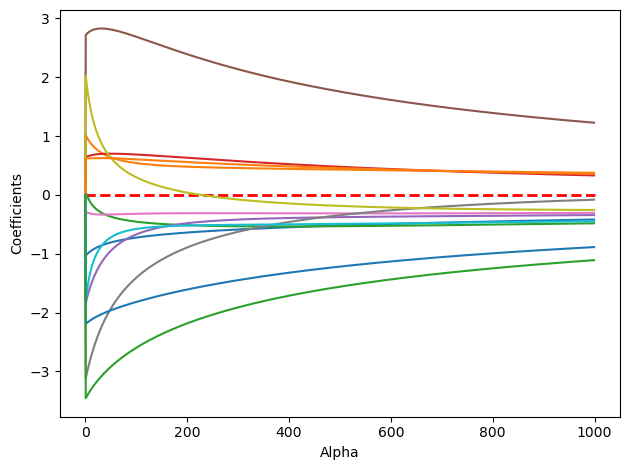

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X_std, y, test_size=0.3, random_state=0)

max_alpha = 1000
# 每個特徵都有迴歸係數，表示特徵對目標的影響程度
coef_ = np.zeros((max_alpha, 13))

# when alpha increase, the model will be simpler
for a in range(1, max_alpha):
    lr_rg = Ridge(alpha=a)
    lr_rg.fit(X_train, y_train)

    y_train_pred = lr_rg.predict(X_train)
    y_test_pred = lr_rg.predict(X_test)
    coef_[a,:] = lr_rg.coef_.reshape(1,-1)
    
plt.hlines(y=0, xmin=0, xmax=max_alpha, color='red', linewidth = 2, linestyle = '--')

for i in range(13):
    plt.plot(range(max_alpha),coef_[:,i])
    
plt.ylabel('Coefficients')
plt.xlabel('Alpha')
plt.tight_layout()
plt.savefig('./output/fig-ridge-decay.png', dpi=300)
plt.show()

### LASSO
An alternative weight decay approach that can lead to sparse $w$ is the LASSO. Depending on the value of $α$, certain weights can become zero much faster than others, which makes the LASSO also useful as a supervised feature selection technique.

NOTE: since $L^-1$-norm has non differentiable points, the solver (optimization method) is different from the one used in the Ridge regression. It will take much more time to train model weights.

In [13]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(
    X_poly, y, test_size=0.3, random_state=0)

for a in [0, 0.001, 0.01, 0.1, 1, 10]:
    lr_rg = Lasso(alpha=a)
    lr_rg.fit(X_train, y_train)

    y_train_pred = lr_rg.predict(X_train)
    y_test_pred = lr_rg.predict(X_test)

    print('\n[Alpha = %.4f]' % a )
    print('MSE train: %.2f, test: %.2f' % (
                    mean_squared_error(y_train, y_train_pred),
                    mean_squared_error(y_test, y_test_pred)))  


[Alpha = 0.0000]
MSE train: 0.55, test: 61.02

[Alpha = 0.0010]
MSE train: 0.64, test: 29.11

[Alpha = 0.0100]
MSE train: 1.52, test: 19.51

[Alpha = 0.1000]
MSE train: 4.34, test: 15.52

[Alpha = 1.0000]
MSE train: 14.33, test: 22.42

[Alpha = 10.0000]
MSE train: 55.79, test: 53.42


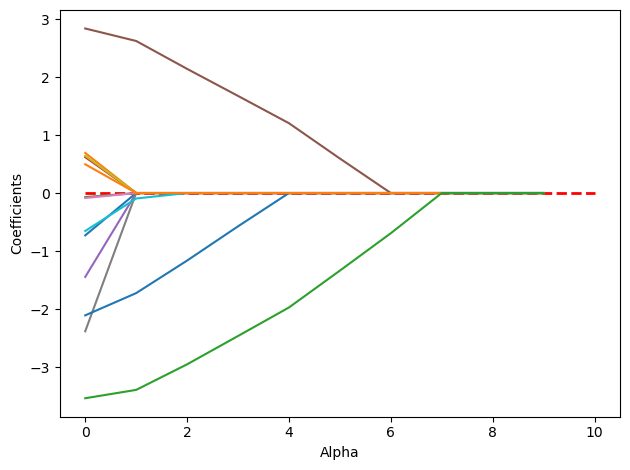

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X_std, y, test_size=0.3, random_state=0)

max_alpha = 10
coef_ = np.zeros((max_alpha,13))

for a in range(10):
    lr_rg = Lasso(alpha=a+0.1)
    lr_rg.fit(X_train, y_train)

    y_train_pred = lr_rg.predict(X_train)
    y_test_pred = lr_rg.predict(X_test)
    coef_[a,:] = lr_rg.coef_.reshape(1,-1)
    
plt.hlines(y=0, xmin=0, xmax=max_alpha, color='red', linewidth = 2, linestyle = '--')

for i in range(13):
    plt.plot(range(max_alpha),coef_[:,i])
    
plt.ylabel('Coefficients')
plt.xlabel('Alpha')
plt.tight_layout()
plt.savefig('./output/fig-ridge-decay.png', dpi=300)
plt.show()

The result shows that as the $α$ increases, the coefficients shrink faster and become exactly zero when $α=8$.

### LASSO for Feature Selection
Since we can choose a suitable regularization strength $α$ to make only part of coefficients become exactly zeros, LASSO can also be treated as a **feature selection technique**.

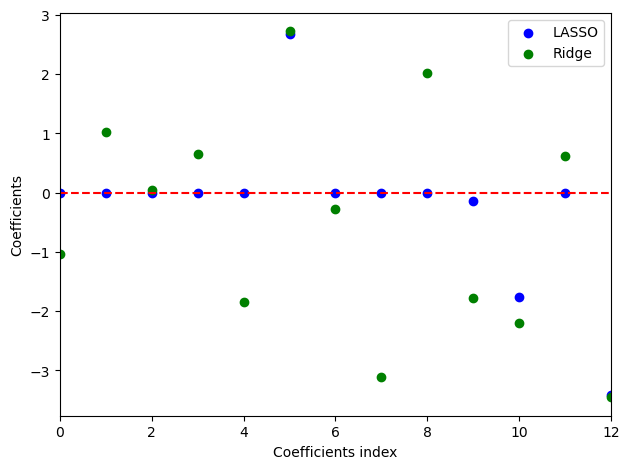

Selected attributes: ['RM' 'TAX' 'PTRATIO' 'LSTAT']


In [15]:
var_num = X_train.shape[1]

lr_lasso = Lasso(alpha = 1)
lr_lasso.fit(X_train, y_train)
lr_ridge = Ridge(alpha = 1)
lr_ridge.fit(X_train, y_train)

plt.scatter(range(var_num),lr_lasso.coef_, label = 'LASSO', color = 'blue')
plt.scatter(range(var_num),lr_ridge.coef_, label = 'Ridge', color = 'green')
plt.hlines(y=0, xmin=0, xmax=var_num-1, color='red', linestyle ='--')
plt.xlim(0,12)
plt.legend(loc = 'upper right')
plt.xlabel('Coefficients index')
plt.ylabel('Coefficients')
plt.tight_layout()
plt.show()

epsilon = 1e-4
idxs = np.where(abs(lr_lasso.coef_) > epsilon)
print('Selected attributes: {}'.format(df.columns.values[idxs]))

這段程式碼的目的是視覺化 Lasso 迴歸和 Ridge 迴歸下的係數，並標識出 Lasso 迴歸中係數為零的特徵。這有助於理解不同正則化方法對特徵選擇的影響。 Lasso 迴歸傾向於將某些特徵的係數縮減為零，從而實現特徵選擇，而 Ridge 迴歸透過 L2 正規化不會將係數縮減為零，但會使它們接近零。

We can plot the pairwise distributions to see the correlation between the selected attributes and MEDV:

All attributes:


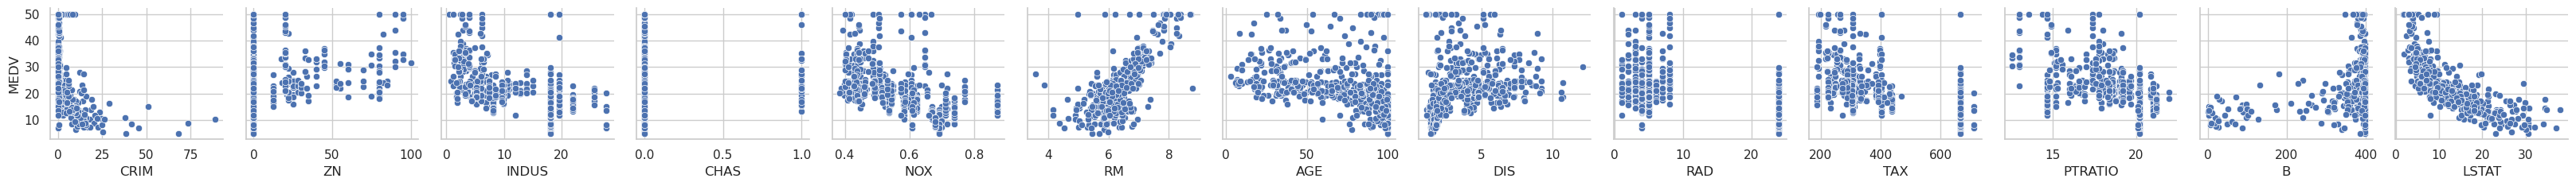

Selected attributes:


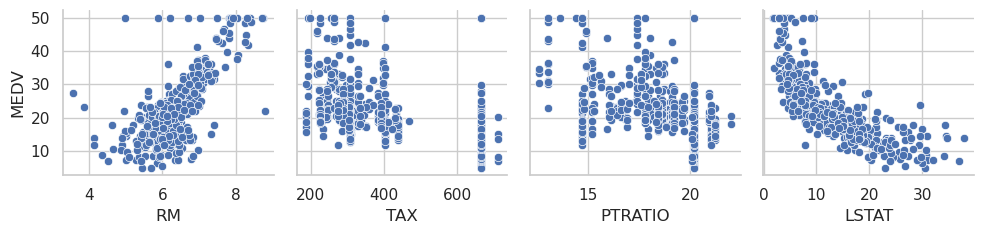

In [17]:
import seaborn as sns

print('All attributes:')
sns.set(style='whitegrid', context='notebook')
sns.pairplot(df, x_vars=df.columns[:-1], y_vars=['MEDV'], size=2.5)
plt.tight_layout()
plt.show()

print('Selected attributes:')
sns.set(style='whitegrid', context='notebook')
sns.pairplot(df,x_vars=df.columns[idxs], y_vars=['MEDV'], size=2.5)
plt.tight_layout()
plt.show()
sns.reset_orig()

As we can see, LASSO extracted attributes that have <font color='red'>more significant correlations with MEDV.</font>

### Ignoring Outliers using RANSAC

Linear regression models can be heavily impacted by the presence of outliers. In certain situations, a very small subset of our data can have a big effect on the estimated model coefficients, as shown below:

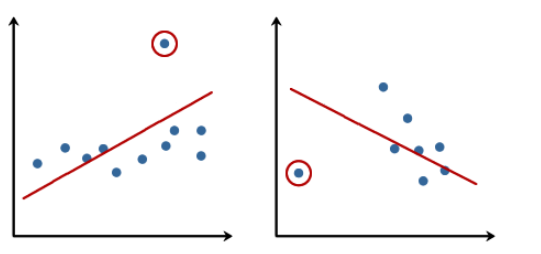

There are many statistical tests that can be used to detect outliers, which are beyond the scope of our course. However, removing outliers usually requires our human judgment as well as domain knowledge.

Next, we present the RANdom SAmple Consensus (RANSAC) algorithm for regression that can completely ignore the outliers and making them irrelevant to final predictions. RANSAC fits a regression model only to a subset of the data, the so-called **inliers**. RANSAC is an iterative algorithm, which can be summarized as follows:

1. Select a random number of samples to be inliers and fit the model.
2. Test all other data points against the fitted model and add those points that fall within a user-given tolerance to the inliers.
3. Refit the model using all inliers.
4. Estimate the error of the fitted model versus the inliers.
5. Terminate the algorithm if the performance meets a certain user-defined threshold or if a fixed number of iterations has been reached; go back to step 1 otherwise.


你提到了使用 RANSAC（RANdom SAmple Consensus）算法来处理线性回归中的异常值。线性回归模型容易受到异常值的影响，因为少数异常值可以显著影响估计的模型系数。RANSAC 是一种用于回归的鲁棒估计方法，它可以完全忽略异常值，使它们对最终预测无关。

RANSAC 是一个迭代算法，其工作步骤如下：

1. 随机选择一组数据点作为内点（inliers）并拟合模型。
2. 测试所有其他数据点是否在拟合的模型容忍度内，将那些落在容忍度范围内的数据点添加到内点中。
3. 使用所有内点重新拟合模型。
4. 估计拟合模型与内点之间的误差。
5. 如果性能满足用户定义的阈值或达到了固定的迭代次数，则终止算法；否则，返回到步骤1。

RANSAC 的核心思想是通过反复拟合模型并识别内点，来找到对模型拟合效果最好的数据子集，从而消除异常值的干扰。这可以提高模型的鲁棒性，特别适用于包含大量异常值的数据集。然而，RANSAC算法的性能取决于容忍度的设置、迭代次数和其他参数的选择，需要谨慎调整。

RANSAC 可以在许多机器学习任务中用于拟合鲁棒性较强的回归模型，特别是在存在异常值时。它在计算机视觉、地理信息系统（GIS）和其他领域中得到广泛应用。

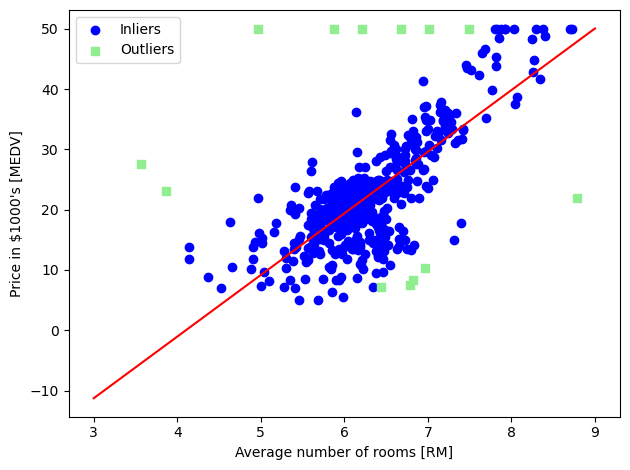


[RANSAC]
Slope (w_1): 10.22    Intercept (w_0): -41.93

[Ordinary least square]
Slope (w_1): 9.10    Intercept (w_0): -34.67


In [18]:
from sklearn.linear_model import RANSACRegressor

X = df['RM'].values[:, np.newaxis]
y = df['MEDV'].values

# 创建 RANSACRegressor 模型
ransac = RANSACRegressor(LinearRegression(), 
            max_trials=100,             # 最大迭代次数
            min_samples=50,             # 每次迭代所需的最小内点数
            residual_threshold=16.0,    # 内点的残差阈值
            random_state=0)
ransac.fit(X, y)

# 内点（inliers）：内点是那些符合模型的数据点
inlier_mask = ransac.inlier_mask_
# 外点（outliers）：外点是那些不符合模型的数据点
outlier_mask = np.logical_not(inlier_mask)
line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask], 
            c='blue', marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask],
            c='lightgreen', marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='red')
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()
print('\n[RANSAC]')
print('Slope (w_1): {:.2f}    Intercept (w_0): {:.2f}'.format(ransac.estimator_.coef_[0],ransac.estimator_.intercept_))


slr = LinearRegression()
slr.fit(X, y)
print('\n[Ordinary least square]')
y_pred = slr.predict(X)
print('Slope (w_1): {:.2f}    Intercept (w_0): {:.2f}'.format(slr.coef_[0],slr.intercept_))

We set the maximum number of iterations of the RANSACRegressor to 100, and via the min_samples parameter we set the minimum number of the randomly chosen samples to be at least 50. Using the residual_metric parameter, we provided a callable lambda function that simply calculates the absolute vertical distances between the fitted line and the sample points. By setting the residual_threshold parameter to 5.0, we only allowed samples to be included in the inlier set if their vertical distance to the fitted line is within 5 distance units, which works well on this particular dataset. By default, scikit-learn uses the the Median Absolute Deviation (MAD) estimate of the target values $y$ to select the inlier threshold. However, the choice of an appropriate value for the inlier threshold is problem-specific, which is one disadvantage of RANSAC. Many different approaches have been developed over the recent years to select a better inlier threshold automatically.

你提到了在使用 RANSACRegressor 时设置了几个重要的参数，这些参数影响了RANSAC算法的运行。以下是这些参数的解释：

1. `max_trials`：這是 RANSAC 算法的最大迭代次數。在你的示例中，將其設置為 100，表示RANSAC將嘗試最多100次不同的內點子集來擬合模型。

2. `min_samples`：這是每次迭代所需的最小內點數。在你的示例中，將其設置為 50，表示每次迭代需要至少選擇50個內點來擬合模型。

3. `residual_metric`：這是一個可呼叫的函數，用於計算數據點與擬合線之間的殘差或誤差。在你的示例中，你提供了一個 lambda 函數，該函數計算擬合線與樣本點之間的絕對垂直距離。

4. `residual_threshold`：這是一個閾值，僅允許垂直距離小於等於該閾值的樣本點被視為內點。在你的示例中，將其設置為 5.0，表示只有垂直距離不超過5個距離單位的樣本點才能被視為內點。

你還提到，默認情況下，scikit-learn 使用目標值 $y$ 的中值絕對偏差（Median Absolute Deviation，MAD）來選擇內點閾值。然而，內點閾值的選擇通常取決於特定問題，這是使用RANSAC的一個缺點。因此，為了更好地自動選擇內點閾值，近年來已經開發了許多不同的方法。

總的來說，通過調整這些參數，你可以控制RANSAC算法的運行方式，以適應不同的數據集和問題。根據問題的特性和數據的性質，你可以選擇合適的參數值來獲得最佳的魯棒擬合結果。

### Validation
Hyperparameters, i.e. constants in the model, may have impact on the model complexity and generalization performance. Validation is another useful regularization technique helping us decide the proper value of hyperparameters. The idea is to split your data into the training, validation, and testing sets and then select the best value based on the Occam's razor for validation performance. So, you don't peep testing set and report optimistic testing performance.

Let's follow the structural risk minimization framework to pick a right degree $P$ in polynomial regression:

你提到了驗證（Validation）作為一種有助於選擇模型超參數的正則化技術。超參數是模型中的常數，它們可以影響模型的複雜性和泛化性能。驗證的目的是將數據集分為訓練集、驗證集和測試集，然後基於驗證性能來選擇最佳的超參數值。這有助於遵循奧卡姆剃刀原則，以防止過度擬合並獲得對模型泛化性能的更好估計，而不是過度關注測試集的性能。

以下是使用結構風險最小化（Structural Risk Minimization，SRM）框架來選擇多項式回歸中正確度數 P 的步驟：

1. **數據準備**：首先，將數據集劃分為訓練集、驗證集和測試集。通常，數據的大部分用於訓練，一小部分用於驗證，以及一小部分用於最終測試。這樣可以確保模型訓練在大數據集上進行，但也有足夠的數據來評估模型性能。

2. **超參數搜索**：在多項式回歸中，超參數是多項式的度數 P。開始嘗試不同的 P 值，通常從較低的度數開始，然後逐漸增加。每次使用訓練集來擬合多項式回歸模型。

3. **驗證性能**：使用驗證集來評估每個不同 P 值下模型的性能。這可以通過計算驗證集上的均方誤差（Mean Squared Error，MSE）或其他性能度量來完成。

4. **選擇最佳 P 值**：選擇在驗證集上性能最佳的 P 值。這通常是使均方誤差最小的 P 值，但也可以根據具體問題選擇其他性能度量。

5. **最終評估**：一旦選擇了最佳的 P 值，可以將它應用於測試集來評估模型的最終性能。這樣可以確保不會過於樂觀地估計模型的性能。

這個過程可以幫助你選擇多項式回歸中適當的度數 P，以平衡模型的複雜性和泛化性能。通過使用驗證集來選擇超參數，你可以更好地防止模型過度擬合訓練數據，同時又能獲得對模型性能的可靠評估。這是一種重要的模型選擇方法。

In [19]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

X = df.iloc[:, :-1].values
y = df['MEDV'].values

sc_x = StandardScaler()
X_std = sc_x.fit_transform(X)

for d in range(1, 7):
    poly = PolynomialFeatures(degree=d)
    X_poly = poly.fit_transform(X_std)

    X_train, X_test, y_train, y_test = train_test_split(
        X_poly, y, test_size=0.3, random_state=0)
    
    X_train, X_valid, y_train, y_valid = train_test_split(
        X_train, y_train, test_size=0.3, random_state=0)
    
    rg = Ridge(alpha=100)
    rg.fit(X_train, y_train)
    
    y_train_pred = rg.predict(X_train)
    y_valid_pred = rg.predict(X_valid)
    y_test_pred = rg.predict(X_test)
    
    print('\n[Degree = %d]' % d)
    print('MSE train: %.2f, valid: %.2f, test: %.2f' % (
                    mean_squared_error(y_train, y_train_pred),
                    mean_squared_error(y_valid, y_valid_pred),
                    mean_squared_error(y_test, y_test_pred))) 


[Degree = 1]
MSE train: 25.00, valid: 21.43, test: 32.09

[Degree = 2]
MSE train: 9.68, valid: 14.24, test: 20.24

[Degree = 3]
MSE train: 3.38, valid: 17.74, test: 18.63

[Degree = 4]
MSE train: 1.72, valid: 16.67, test: 30.98

[Degree = 5]
MSE train: 0.97, valid: 59.73, test: 57.02

[Degree = 6]
MSE train: 0.60, valid: 1444.08, test: 33189.41


We pick $P=2$ because it gives a low enough validation error at the simplest complexity. Then, we report the testing error over the test set. In general, you may not be able to pick the $P$ that gives the lowest testing performance. In this case you get the 20.24% testing error instead of 18.63%. But that's the right way to do error reporting.

## <center>Assignment</center>
In this assignment, we would like to predict the success of shots made by basketball players in the NBA.

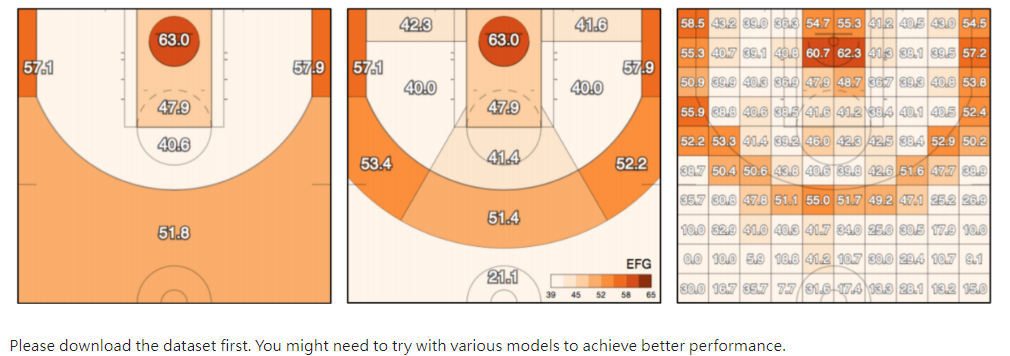

In [20]:
import pandas as pd
import numpy as np

In [21]:
# download the dataset
import urllib.request

urllib.request.urlretrieve("https://nthu-datalab.github.io/ml/labs/05_Regularization/data/X_train.csv", "./data/X_train.csv")
urllib.request.urlretrieve("https://nthu-datalab.github.io/ml/labs/05_Regularization/data/y_train.csv", "./data/y_train.csv")
urllib.request.urlretrieve("https://nthu-datalab.github.io/ml/labs/05_Regularization/data/X_test.csv", "./data/X_test.csv")

X_train = pd.read_csv('./data/X_train.csv')
y_train = pd.read_csv('./data/y_train.csv')

In [22]:
print(X_train.shape)
print(X_train.columns)
print(y_train.columns)

(85751, 8)
Index(['PERIOD', 'GAME_CLOCK', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME',
       'SHOT_DIST', 'PTS_TYPE', 'CLOSE_DEF_DIST'],
      dtype='object')
Index(['FGM'], dtype='object')


In [23]:
X_train.head()

,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSE_DEF_DIST
0,1,358,2.4,0,3.2,20.6,2,4.5
1,1,585,8.3,0,1.2,3.0,2,0.5
2,1,540,19.9,0,0.6,3.5,2,3.2
3,1,392,9.0,0,0.9,21.1,2,4.9
4,3,401,22.7,0,0.7,4.1,2,2.9


In [25]:
y_train.head()

,FGM
0,0
1,1
2,1
3,1
4,1
